In [1]:
%matplotlib inline

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# import torch as T
'''import torch
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim'''
import pandas as pd
import numpy as np
import math
import random

In [2]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device= "cpu"
print("DEVICE: ", device)

('DEVICE: ', 'cpu')


In [4]:
df = pd.read_csv('diuretic_data_all_new_3.csv', index_col=None)
cols = df.columns.str.replace(" ", "_")
df.columns = cols

df.head()

icustay_id  hour  subject_id  hadm_id  specimen  aado2  baseexcess  \
0      200001     1       55973   152234       NaN    NaN         1.0   
1      200001     2       55973   152234       NaN    NaN         NaN   
2      200001     3       55973   152234       NaN    NaN         NaN   
3      200001     4       55973   152234       NaN    NaN         NaN   
4      200001     5       55973   152234       NaN    NaN         NaN   

   bicarbonate  totalco2  carboxyhemoglobin  ...  NICU  SICU  TSICU  mv  \
0          NaN      28.0                NaN  ...     0     0      0   0   
1          NaN       NaN                NaN  ...     0     0      0   0   
2          NaN       NaN                NaN  ...     0     0      0   0   
3          NaN       NaN                NaN  ...     0     0      0   0   
4          NaN       NaN                NaN  ...     0     0      0   0   

   death  congestive_heart_failure  amount_binary  vaso_binary  death_2  \
0      0                       1.0            0.0          0.0        0   
1      0                       1.0            0.0          0.0        0   
2      0                       1.0            0.0          0.0        0   
3      0                       1.0            0.0          0.0        0   
4      0                       1.0            1.0          0.0        0   

   release  
0        0  
1        0  
2        0  
3        0  
4        0  

[5 rows x 122 columns]

In [6]:
data = df[['icustay_id', 'hour',\
					"baseexcess", "bicarbonate", "totalco2",\
					"hemoglobin", "lactate","tidalvolume","calcium","glucose",\
					"so2", "pco2", "ph", "po2", "potassium", "bun",\
					"temperature","bilirubin", "creatinine", "platelet", "urineoutput", "heartrate",\
					"sysbp", "diasbp", "meanbp", "resprate", "tempc", "spo2", "weight",\
					"amount","diuretic", "mv", "amount_binary", "vaso_binary", "death_2", "release",\
					"pre_icu_fluid", "gender", "age",\
					"gcs", "gcsmotor", "gcsverbal", "gcseyes",\
					"valvular_disease", "peripheral_vascular", "hypertension", "paralysis", "chronic_pulmonary",\
					"diabetes_uncomplicated", "diabetes_complicated", "hypothyroidism", "liver_disease", "aids", "lymphoma",\
					"metastatic_cancer", "solid_tumor", "rheumatoid_arthritis", "coagulopathy", "obesity", "deficiency_anemias",\
					"alcohol_abuse", "drug_abuse", "endstagerenlfail", "congestive_heart_failure"]]

# Carry forward

print("DIURETIC CHECK 0", data.groupby("icustay_id")["diuretic"].last().sum())
# REMOVE PATIENTS WITH 0 pre-ICU fluid
print("TOTAL NUM PATIENTS", data.groupby('icustay_id').ngroups)
data = data.groupby('icustay_id').filter(lambda x: (x['pre_icu_fluid'].min()> 0 )& \
                                         (x["urineoutput"].min()>=0) &\
                                         ((x["tempc"].min() > 15) | (x["temperature"].min()> 15))) 

print("Number of patients After exclusion criteria: ", data.groupby('icustay_id').ngroups)


	# # REMOVE PATIENTS IF ANY OF THE FOLLOWING COLUMNS EACH CONTAIN ALL NAN VALUES
	# for column in ["lactate", "baseexcess", "weight", "urineoutput", "platelet", "so2"]:
	# 	data = data.groupby('icustay_id').filter(lambda x: x[column].isnull().mean() > 0)
	# # OR REMOVE PATIENTS WHERE NAN VALUES EXCEED SOME THRESHOLD WHEN COLUMNS ARE POOLED
    
columns = ["lactate", "baseexcess", "weight", "urineoutput", "platelet", "so2"]
data = data.groupby('icustay_id').filter(lambda x: x[columns].isnull().mean().mean() > 0.1)

print("DIURETIC CHECK 2", data.groupby("icustay_id")["diuretic"].last().sum())

('DIURETIC CHECK 0', 3466)
('TOTAL NUM PATIENTS', 61508)
('Number of patients After exclusion criteria: ', 7996)
('DIURETIC CHECK 2', 1372)


In [7]:
gender = {'M' : 1, 'F' : 0}
data['gender'] = data['gender'].map(gender)

In [8]:
continuous_vars = ["baseexcess", "bicarbonate", "totalco2", \
                    "hemoglobin", "lactate", \
                    "so2", "pco2", "ph", "po2", "potassium", "bun",\
                    "temperature","bilirubin", "creatinine", "platelet", "urineoutput", "heartrate", \
                    "sysbp", "diasbp", "meanbp", "resprate", "tempc", "spo2", "weight",
                    "gcs", "gcsmotor", "gcsverbal", "gcseyes","tidalvolume",\
                    "amount", "age","calcium","glucose","heartrate",
                    "pre_icu_fluid"]

categorical_vars = ["mv", "amount_binary", "vaso_binary", "death_2", "release"]

static_vars = ["gender", "age", \
					"valvular_disease", "peripheral_vascular", "hypertension", "paralysis", "chronic_pulmonary", \
					"diabetes_uncomplicated", "diabetes_complicated", "hypothyroidism", "liver_disease", "aids", "lymphoma", \
					"metastatic_cancer", "solid_tumor", "rheumatoid_arthritis", "coagulopathy", "obesity", "deficiency_anemias", \
					"alcohol_abuse", "drug_abuse", "endstagerenlfail", "congestive_heart_failure", \
					"pre_icu_fluid"]

## vaso_binary, death_2, amount binary

data_first = data.groupby('icustay_id').first()[continuous_vars]

In [9]:
qtls = {}

#qtls = df[continuous_vars].quantile(q=0.99)

qtls["heartrate"] = 250
qtls["po2"] = 600
qtls["pco2"] = 150
qtls["baseexcess"] = 50
qtls["diasbp"] = 200
qtls["potassium"] = 30
qtls["amount"] = 7000
qtls["urineoutput"] = 3000
qtls["pre_icu_fluid"] = 7000
qtls["diasbp"] = 200
qtls["sysbp"] = 250
qtls["bun"] = 100
qtls["weight"] = 200
qtls["potassium"] = 30
qtls["bun"] = 100
qtls["urineoutput"] = 8000
qtls["pre_icu_fluid"] = 10000
qtls["calcium"] = 80
qtls["tidalvolume"] = 4000
qtls["glucose"] = 1000
qtls["platelet"] = 1500
qtls["meanbp"] = 220

qtls

string = " | ".join(["({0} > {1})".format(idx, val) for idx, val in qtls.iteritems()])
string = string + "|(meanbp.isnull())"

print("Number of patients after filtering", len(data_first))

exclude_ids =  data_first.query(string, engine='python').index


data_filtered = data_first[~data_first.index.isin(exclude_ids)]

print("Number of patients before filtering", len(data_filtered))


('Number of patients after filtering', 7996)
('Number of patients before filtering', 7630)


## Before fitlering

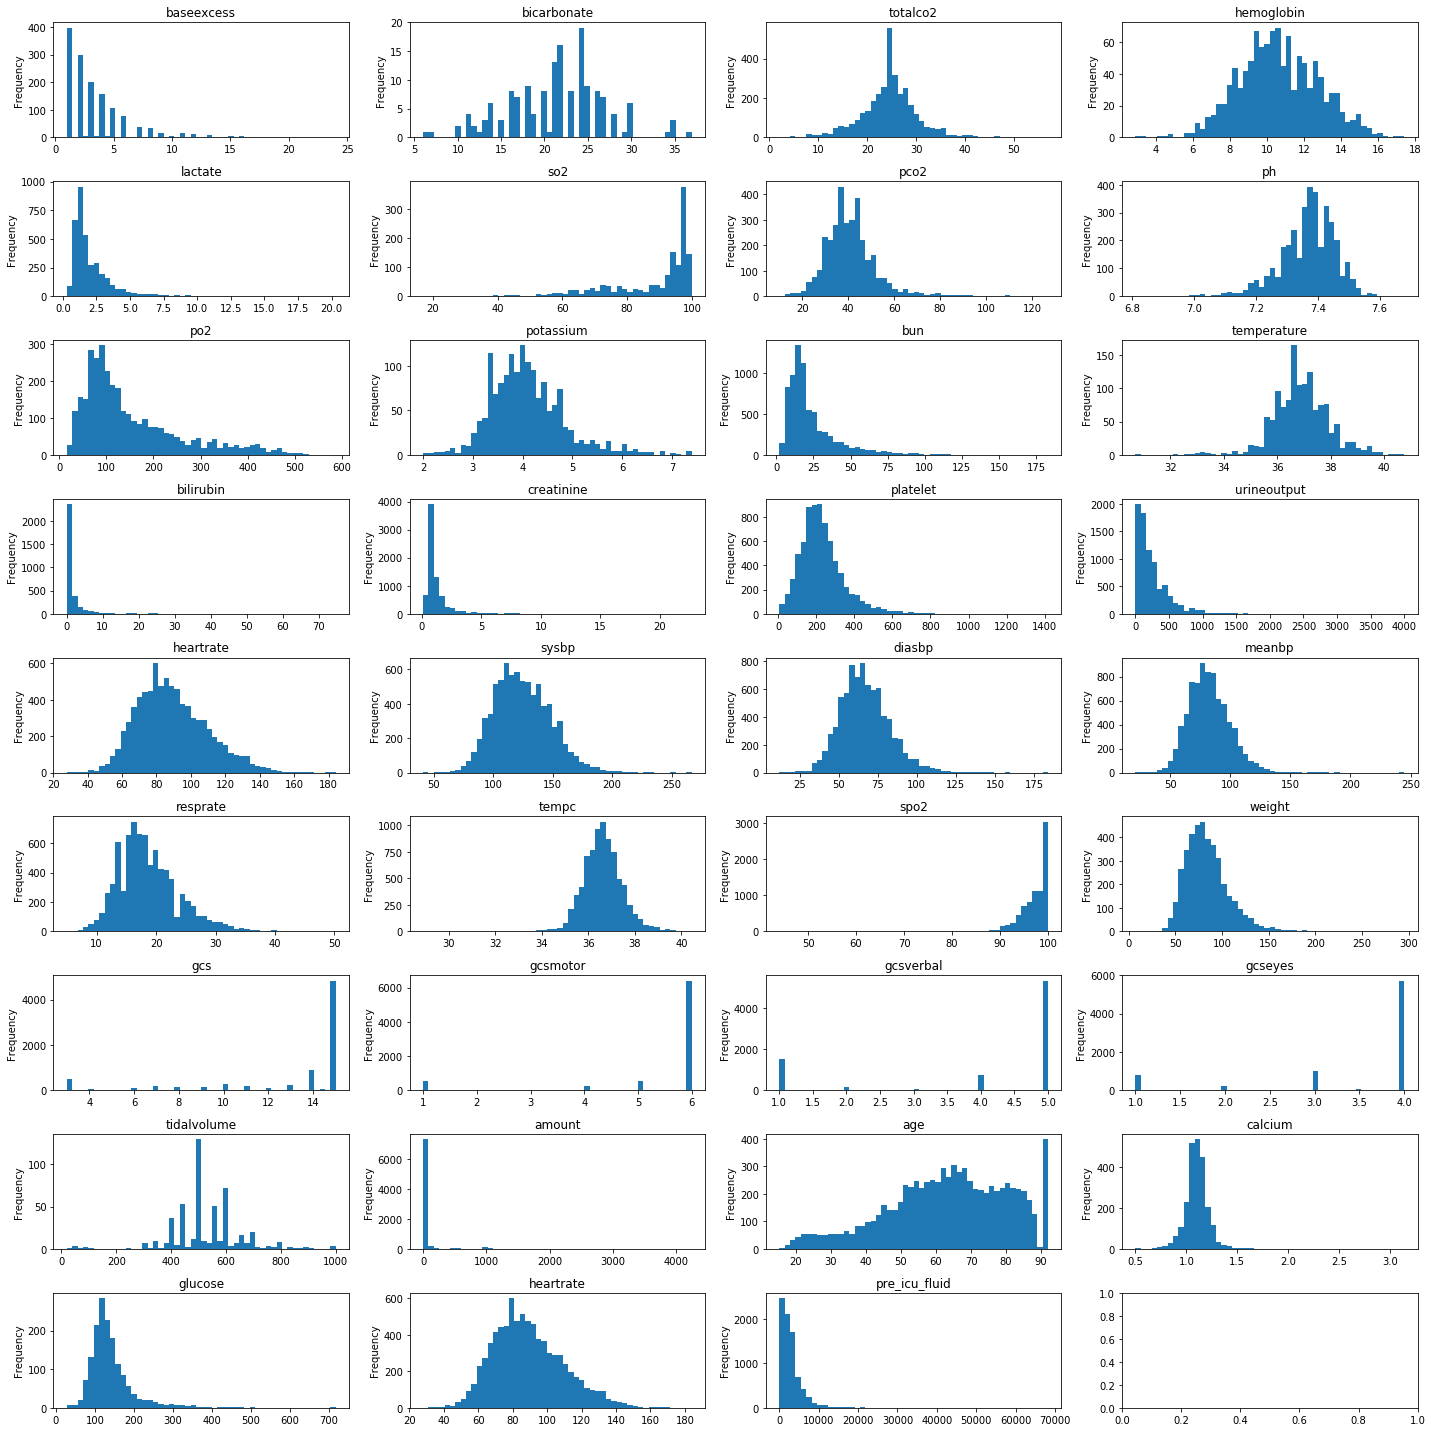

In [10]:
fig, axX = plt.subplots(9, 4, figsize=(20, 20))

for idx in range(35):
    ax = axX.flatten()[idx]
    data_first.iloc[:, idx].plot.hist(ax=ax, bins=50)
    ax.set_title(data_first.columns[idx])
fig.tight_layout()

## After filtering

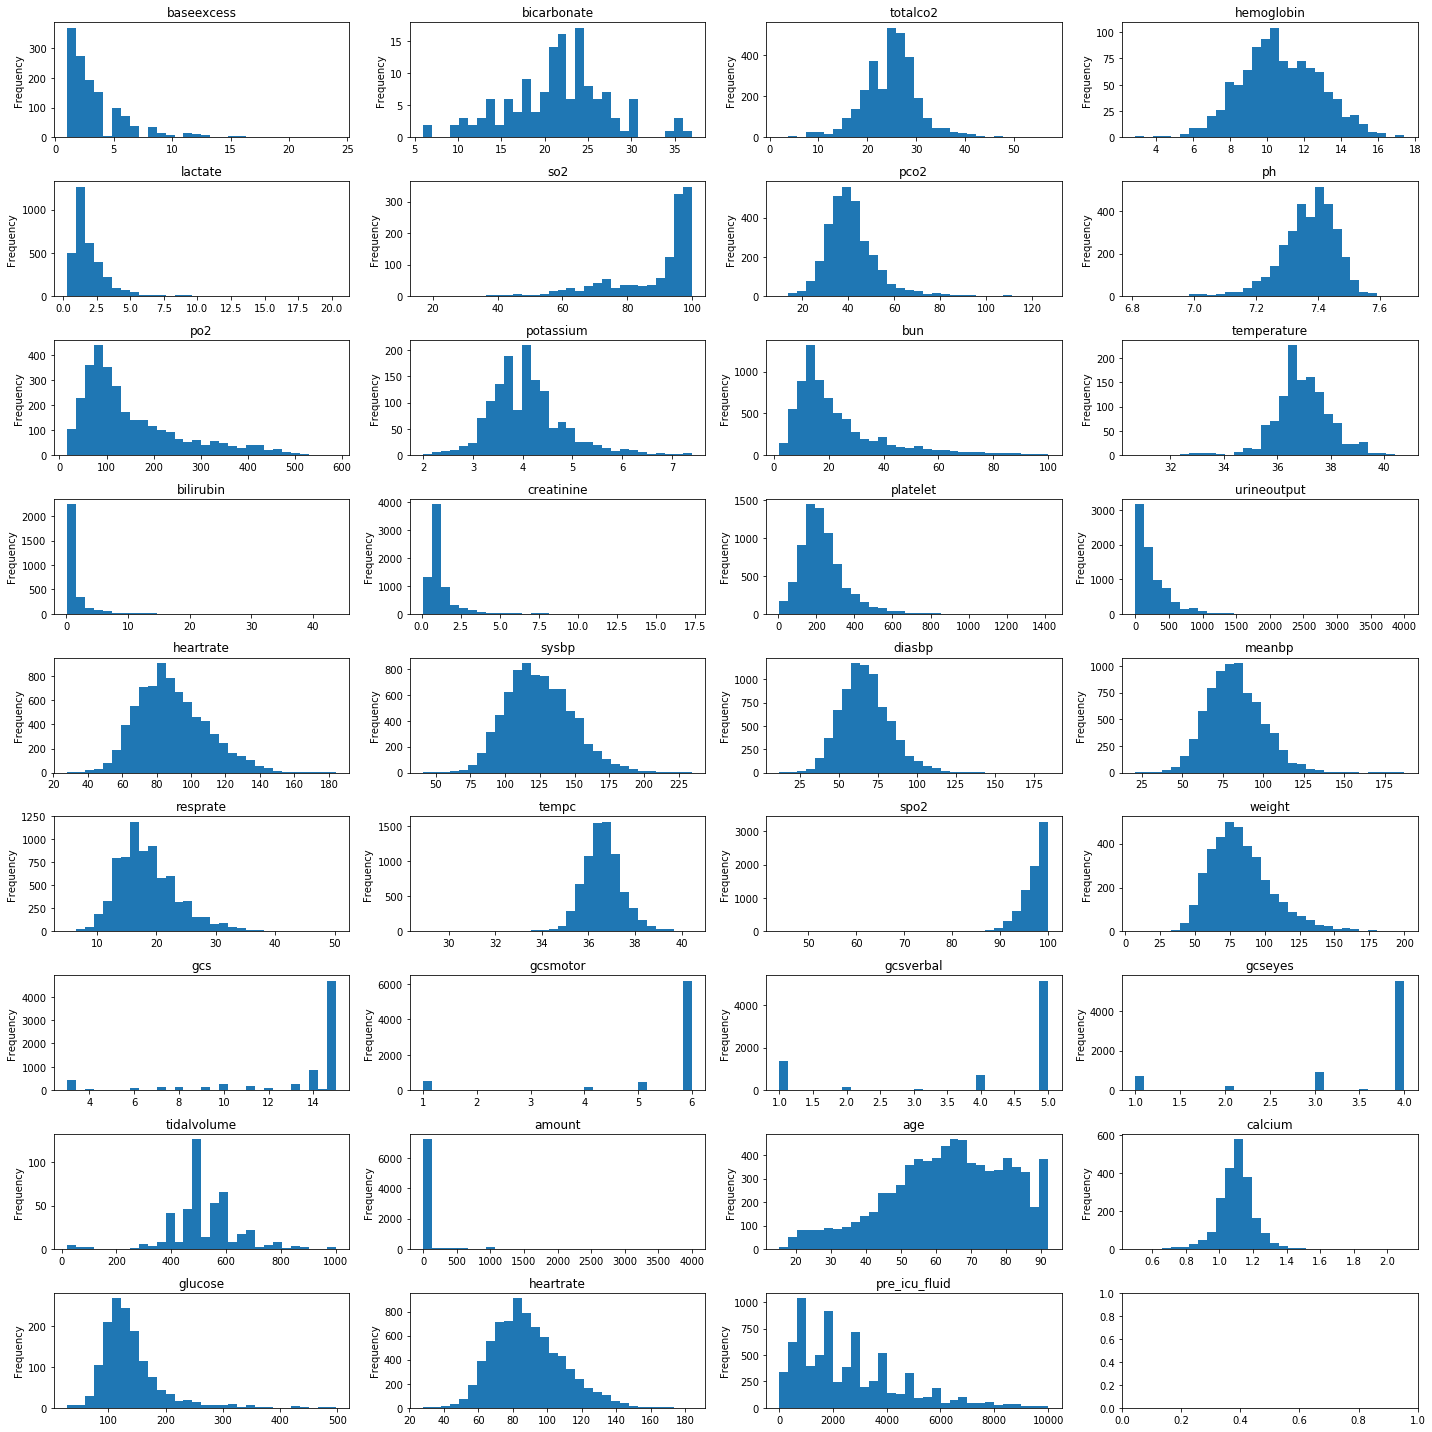

In [11]:
fig, axX = plt.subplots(9, 4, figsize=(20, 20))

for idx in range(35):
    ax = axX.flatten()[idx]
    data_filtered.iloc[:, idx].plot.hist(ax=ax, bins=30)
    ax.set_title(data_filtered.columns[idx])
fig.tight_layout()

In [13]:
len(df[["mv", "amount_binary", "vaso_binary", "death_2", "release"]]) - df[["mv", "amount_binary", "vaso_binary", "death_2", "release"]].count()

mv               0
amount_binary    0
vaso_binary      0
death_2          0
release          0
dtype: int64

In [14]:
filtered_data = data[data.icustay_id.isin(data_filtered.index.unique().tolist())]

## Carry forward values 

filtered_data = filtered_data.groupby("icustay_id").ffill()

print(len(filtered_data) - filtered_data.count())

icustay_id                       0
hour                             0
baseexcess                  267028
bicarbonate                 317683
totalco2                    197229
hemoglobin                  290802
lactate                     187248
tidalvolume                 297006
calcium                     234668
glucose                     268563
so2                         268060
pco2                        197229
ph                          187070
po2                         197164
potassium                   270964
bun                          40589
temperature                 265264
bilirubin                   199497
creatinine                   40520
platelet                     43648
urineoutput                  19141
heartrate                     7211
sysbp                         8423
diasbp                        8424
meanbp                        7569
resprate                      7265
tempc                        10557
spo2                          7644
weight              

In [83]:
for i in continuous_vars:
    if i != "pre_icu_fluid":
        filtered_data[i].fillna(-100, inplace=True)

print(len(filtered_data) - filtered_data.count())

icustay_id                    0
hour                          0
baseexcess                    0
bicarbonate                   0
totalco2                      0
hemoglobin                    0
lactate                       0
tidalvolume                   0
calcium                       0
glucose                       0
so2                           0
pco2                          0
ph                            0
po2                           0
potassium                     0
bun                           0
temperature                   0
bilirubin                     0
creatinine                    0
platelet                      0
urineoutput                   0
heartrate                     0
sysbp                         0
diasbp                        0
meanbp                        0
resprate                      0
tempc                         0
spo2                          0
weight                        0
amount                        0
                           ... 
death_2 

In [84]:
filtered_data.head()
#filtered_data.to_csv('diuretic_filtered_data.csv', index=False)


icustay_id  hour  baseexcess  bicarbonate  totalco2  hemoglobin  lactate  \
216      200016     1      -100.0       -100.0    -100.0      -100.0   -100.0   
217      200016     2      -100.0       -100.0    -100.0      -100.0   -100.0   
218      200016     3      -100.0       -100.0    -100.0      -100.0   -100.0   
219      200016     4      -100.0       -100.0    -100.0      -100.0   -100.0   
220      200016     5      -100.0       -100.0    -100.0      -100.0   -100.0   

     tidalvolume  calcium  glucose  ...  metastatic_cancer  solid_tumor  \
216       -100.0   -100.0   -100.0  ...                  0            0   
217       -100.0   -100.0   -100.0  ...                  0            0   
218       -100.0   -100.0   -100.0  ...                  0            0   
219       -100.0   -100.0   -100.0  ...                  0            0   
220       -100.0   -100.0   -100.0  ...                  0            0   

     rheumatoid_arthritis  coagulopathy  obesity  deficiency_anemias  \
216                     0             0        0                   0   
217                     0             0        0                   0   
218                     0             0        0                   0   
219                     0             0        0                   0   
220                     0             0        0                   0   

     alcohol_abuse  drug_abuse  endstagerenlfail  congestive_heart_failure  
216              0           0                 0                       0.0  
217              0           0                 0                       0.0  
218              0           0                 0                       0.0  
219              0           0                 0                       0.0  
220              0           0                 0                       0.0  

[5 rows x 64 columns]

In [5]:
test_1 = pd.read_csv(data_dir + 'testing_no_treatment_1_2_1000.csv', index_col=0)

In [12]:
df_filtered = test_1[test_1.id.isin(tmp2.index)]
assert(df_filtered.id.nunique() == tmp2.shape[0])

cols = df_filtered.columns.str.replace("_", " ")
df_filtered.columns = cols


df_filtered.to_csv('../downloads/6c_testing_no_tx_filtered_1_2_1000.csv', index=False)

In [16]:
def get_self_map(categorical_vars): 
	categ_name_map = {}
	for var in categorical_vars:
		categ_name_map[var] = var
	return categ_name_map

'''
HELPER METHOD TO MAP VARIABLE NAME TO INDEX IN ENCODED VECTOR
NOTE: THIS METHOD ASSUMES THE ORDER CATEGORICAL, CONTINUOUS, STATIC
'''
def get_index_map(df, categorical_vars, continuous_vars):
	var_to_index = {}
	index = 0
	for categ_var in categorical_vars: 
		num_categories = len([col for col in df if col.startswith(categ_var)])
		var_to_index[categ_var] = index
		index += num_categories
	for contin_var in continuous_vars: 
		var_to_index[contin_var] = index
		index += 1
	return var_to_index

'''
HELPER METHOD TO MAP VARIABLE NAME TO AVG AND STD 
'''
def get_avg_std_map(df, cols_to_norm):
	var_to_avg_std = {}
	for var in cols_to_norm: 
		avg = df[var].mean()
		std = df[var].std()
		var_to_avg_std[var] = (avg, std)
	return var_to_avg_std

'''
HELPER METHOD TO MAP VARIABLE NAME TO MIN MAX VALUES
'''
def get_min_max_map(df, cols_to_norm):
	var_to_min_max = {}
	for var in cols_to_norm: 
		min_val = df[var].min()
		max_val = df[var].max()
		var_to_min_max[var] = (min_val, max_val)
	return var_to_min_max

In [36]:
def get_train_val_data(data): 
	# data = pd.read_csv("../CVSim/train_1000.csv")
	# SELECT THE RELEVANT VARIABLES
	data = data[["id", "LVP", "LVQ", "AP", "AQ", "AV", "CVP", "RVP", "RVQ",\
				"PVV", "HR", "AR", "VT", "RVC", "LVC", "TBV", "Pth", \
				"pulmonaryEdema", "MAP",  "bolus", "vasopressor", "sbp"]]

	# PRORATE NA VALUES
	data = data.fillna(method="ffill")
	# STARTING NAN VALUES SET TO 0
	data = data.fillna(0)

	# NORMALIZE CERTAIN CONTINUOUS FIELDS: 
	cols_to_norm = ["LVP", "LVQ","AP", "AQ", "AV", "CVP", "RVP", "RVQ", \
					"PVV", "HR", "AR", "VT", "RVC", "LVC", "TBV", "Pth",\
					"MAP", "bolus", "vasopressor", "sbp"]
	avg_std_map = get_avg_std_map(data, cols_to_norm)
# 	data[cols_to_norm] = data[cols_to_norm].apply(lambda x: (x - x.mean())/x.std())
	data = data.fillna(0)

	# GET NORMALIZED MIN AND MAX OF EACH VAR
	min_max_map = get_min_max_map(data, cols_to_norm)

	# SEPARATE VARIABLES INTO CONTINUOUS, CATEGORICAL, STATIC, TREATMENT, OUTCOME
	continuous_vars = ["LVP", "LVQ", "AP", "AQ", "AV", "CVP", "RVP", "RVQ",\
					"PVV", "HR", "AR", "VT", "RVC", "LVC", "TBV", "Pth",\
					"MAP", "bolus", "vasopressor", "sbp"]
	categorical_vars = ["pulmonaryEdema"]

	# ONE HOT ENCODE CATEGORICAL VARS
	categ_name_map = get_self_map(categorical_vars)
	data = pd.get_dummies(data, prefix=categ_name_map, columns=categorical_vars)
	# GET THE OVERALL VARIABLE TO INDEX MAPPING. ASSUME ORDER IS CATEGORICAL, CONTINUOUS, STATIC VARS
	var_to_index_map = get_index_map(data, categorical_vars, continuous_vars)
	categ_inputs = []
	contin_inputs = []
	categ_targets = []
	contin_targets = []
	icustay_ids = []
	ensemble_num = 1
	for icustay_id, df_icustay_id in data.groupby('id'):
		patient_data = df_icustay_id
		(num_timesteps, _) = patient_data.shape
		if num_timesteps > ensemble_num: 

			# EXTRACT CONTINUOUS VARS
			contin_input = torch.Tensor(patient_data[continuous_vars].values[0:-ensemble_num, :]).to(device).unsqueeze(0)
			if contin_input.shape[1] != 65:
				print(icustay_id, contin_input.shape)
				continue
			# EXTRACT ICUSTAY ID
			icustay_ids.append(icustay_id)
			contin_inputs.append(contin_input)
			contin_target = torch.Tensor(patient_data[continuous_vars].values[ensemble_num:, :]).to(device).unsqueeze(0)
			contin_targets.append(contin_target)
			# EXTRACT CATEGORICAL VARS
			categ_input = torch.Tensor(patient_data[patient_data.columns[pd.Series(patient_data.columns).str.startswith(tuple(categorical_vars))]].values[0:-ensemble_num, :]).to(device).unsqueeze(0)
			categ_inputs.append(categ_input)
			categ_target = torch.Tensor(patient_data[patient_data.columns[pd.Series(patient_data.columns).str.startswith(tuple(categorical_vars))]].values[ensemble_num:, :]).to(device).unsqueeze(0)
			categ_targets.append(categ_target)
	
	# SHUFFLE ALL THE DATA
	all_data = list(zip(icustay_ids, categ_inputs, contin_inputs, categ_targets, contin_targets))
	np.random.seed(1)
	np.random.shuffle(all_data)
	(icustay_ids, categ_inputs, contin_inputs, categ_targets, contin_targets) = zip(*all_data)

	total_num_patients = len(icustay_ids)
	num_train = math.floor(0.7*total_num_patients)
	return (icustay_ids[:num_train], categ_inputs[:num_train], contin_inputs[:num_train], categ_targets[:num_train], contin_targets[:num_train], \
			icustay_ids[num_train:], categ_inputs[num_train:], contin_inputs[num_train:], categ_targets[num_train:], contin_targets[num_train:], \
categorical_vars, continuous_vars, var_to_index_map, avg_std_map, min_max_map)

In [37]:
df_filtered = pd.read_csv("./g_network_data/6c_treatment_filtered_10000.csv") # treatment_filtered_normalized_1000
                          
(train_icustay_ids, train_categ_input, train_contin_input, train_categ_target, train_contin_target,\
 val_icustay_ids, val_categ_input, val_contin_input, val_categ_target, val_contin_target,\
 categorical_vars, continuous_vars, var_to_index_map, avg_std_map, min_max_map) = get_train_val_data(df_filtered)

9784.0 torch.Size([1, 23, 20])


In [38]:
train_contin_input = torch.stack(train_contin_input).squeeze(1)
train_categ_input = torch.stack(train_categ_input).squeeze(1)

val_contin_input = torch.stack(val_contin_input).squeeze(1)
val_categ_input = torch.stack(val_categ_input).squeeze(1)

## Line plots

Text(0.5, 0.98, 'Training')

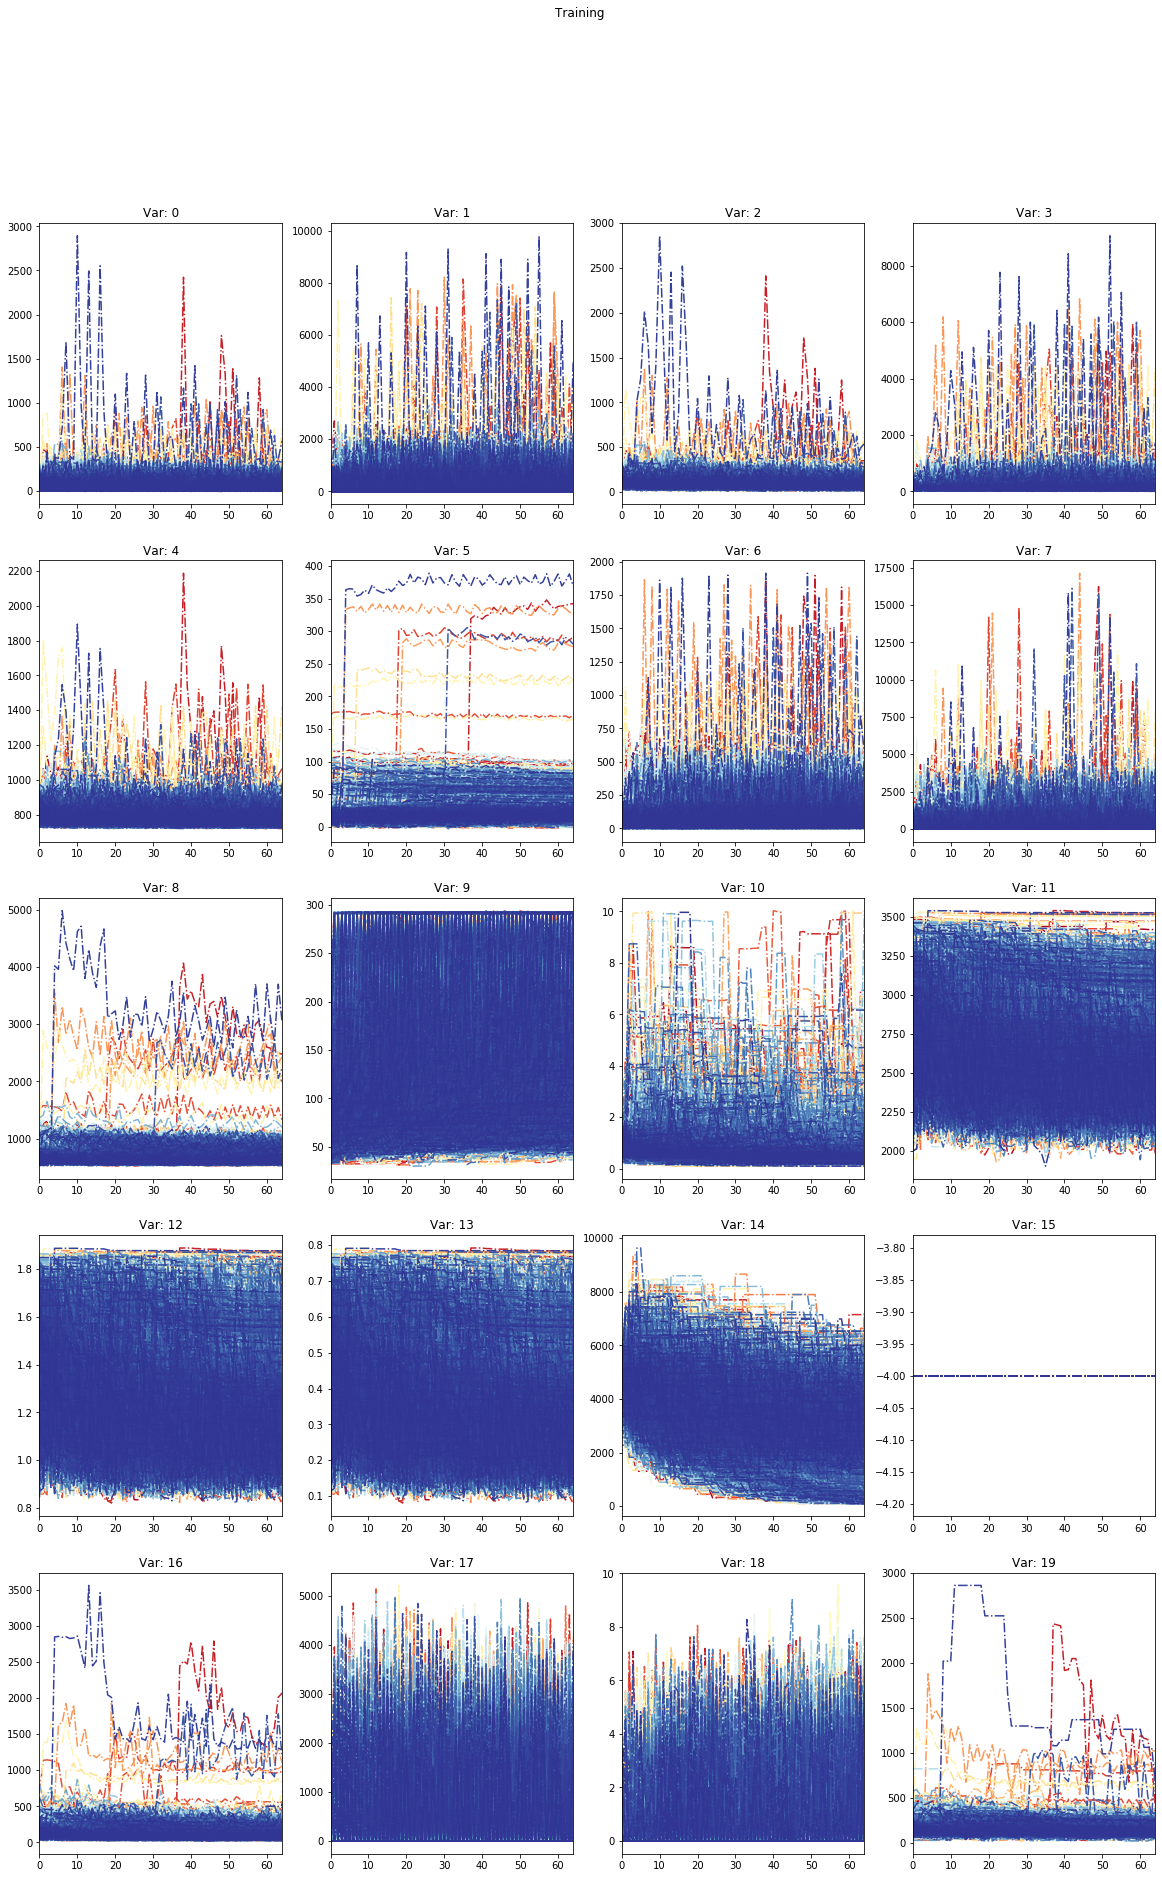

In [39]:
fig, axX = plt.subplots(5, 4, figsize=(20, 30))

for idx in range(20):
    ax = axX.flatten()[idx]
    
    df = pd.DataFrame(train_contin_input[:, :, idx].data.numpy())
    df.T.plot.line(ax=ax, legend=False, ls='-.', cmap='RdYlBu')
    ax.set_title('Var: {}'.format(idx))
fig.suptitle('Training')

Text(0.5, 0.98, 'Validation')

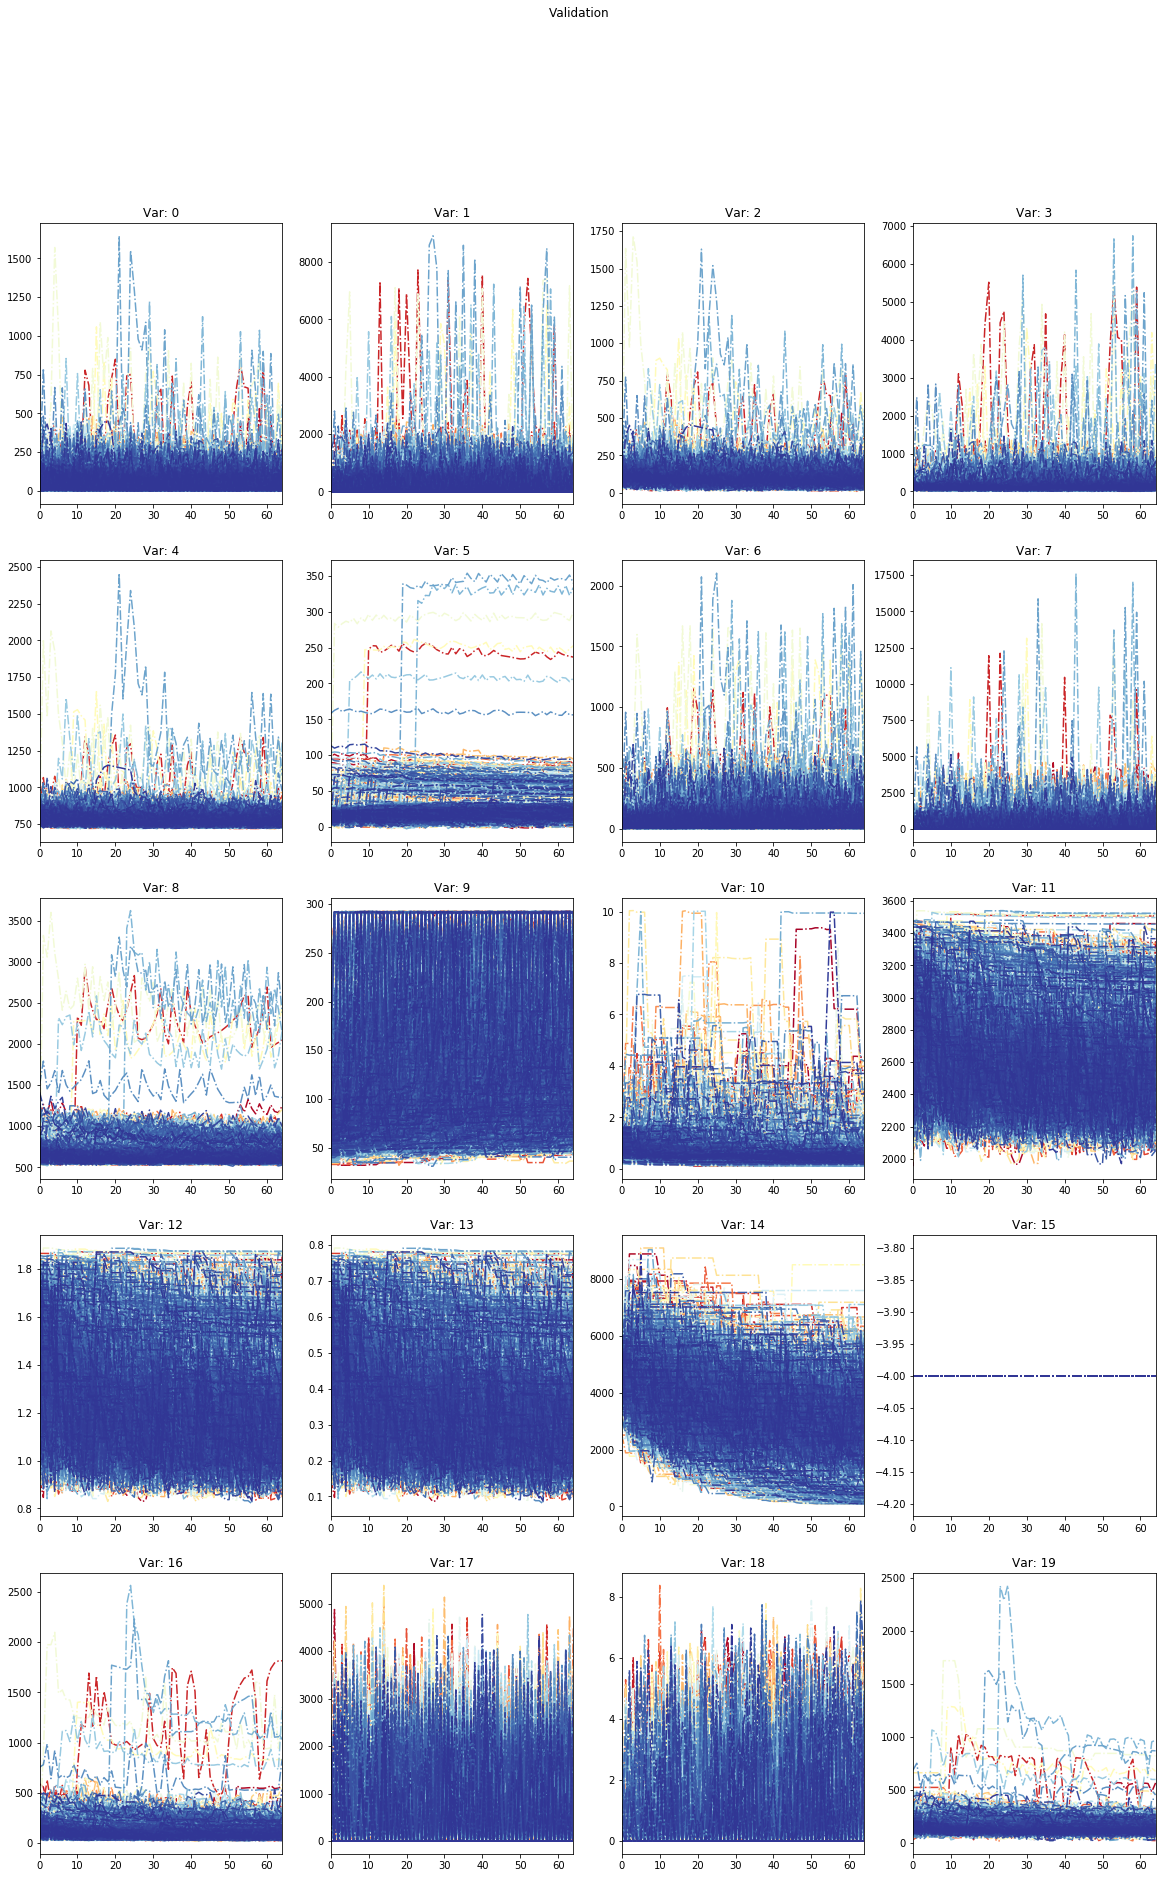

In [40]:
fig, axX = plt.subplots(5, 4, figsize=(20, 30))

for idx in range(20):
    ax = axX.flatten()[idx]
    
    df = pd.DataFrame(val_contin_input[:, :, idx].data.numpy())
    df.T.plot.line(ax=ax, legend=False, ls='-.', cmap='RdYlBu')
    ax.set_title('Var: {}'.format(idx))
fig.suptitle('Validation')

## Boxplot

In [19]:
def boxplt (data, ttl): 
    fig, axX = plt.subplots(20, 1, figsize=(15, 60))
    for idx in range(20):
        ax = axX.flatten()[idx]
        df = pd.DataFrame(data[:, :, idx].data.numpy())
        ax.boxplot(df.values)
        ax.set_title('Var: {}'.format(idx))
    plt.tight_layout()
    fig.suptitle(ttl)    

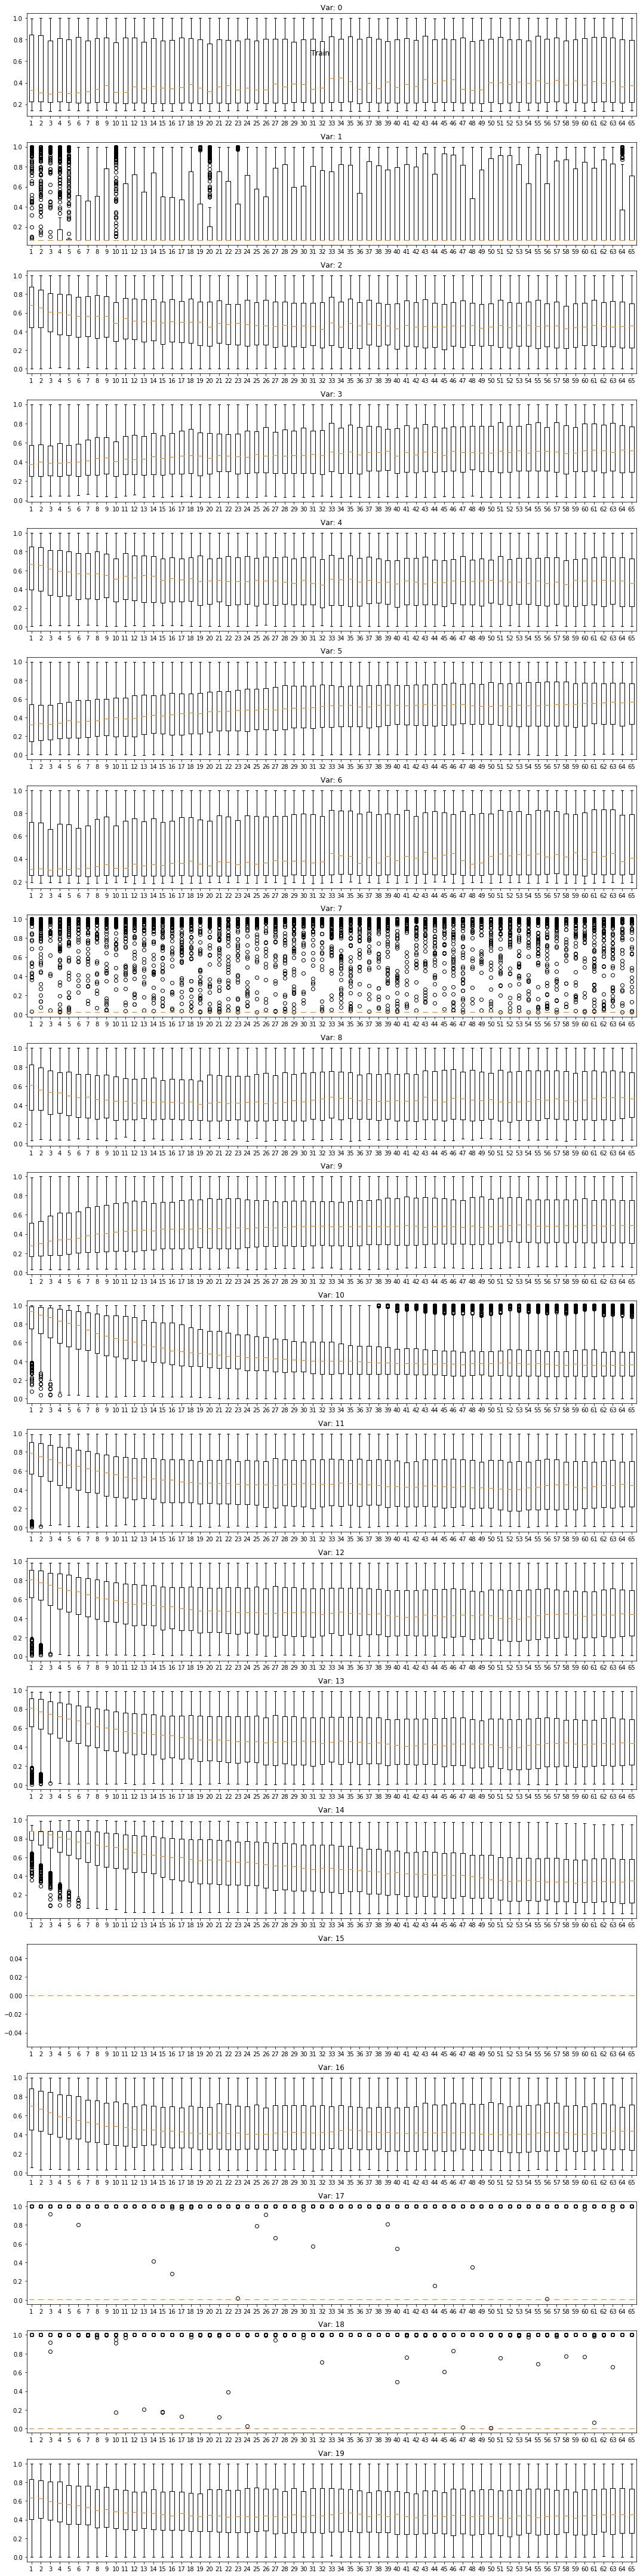

In [20]:
boxplt (train_contin_input, 'Train')

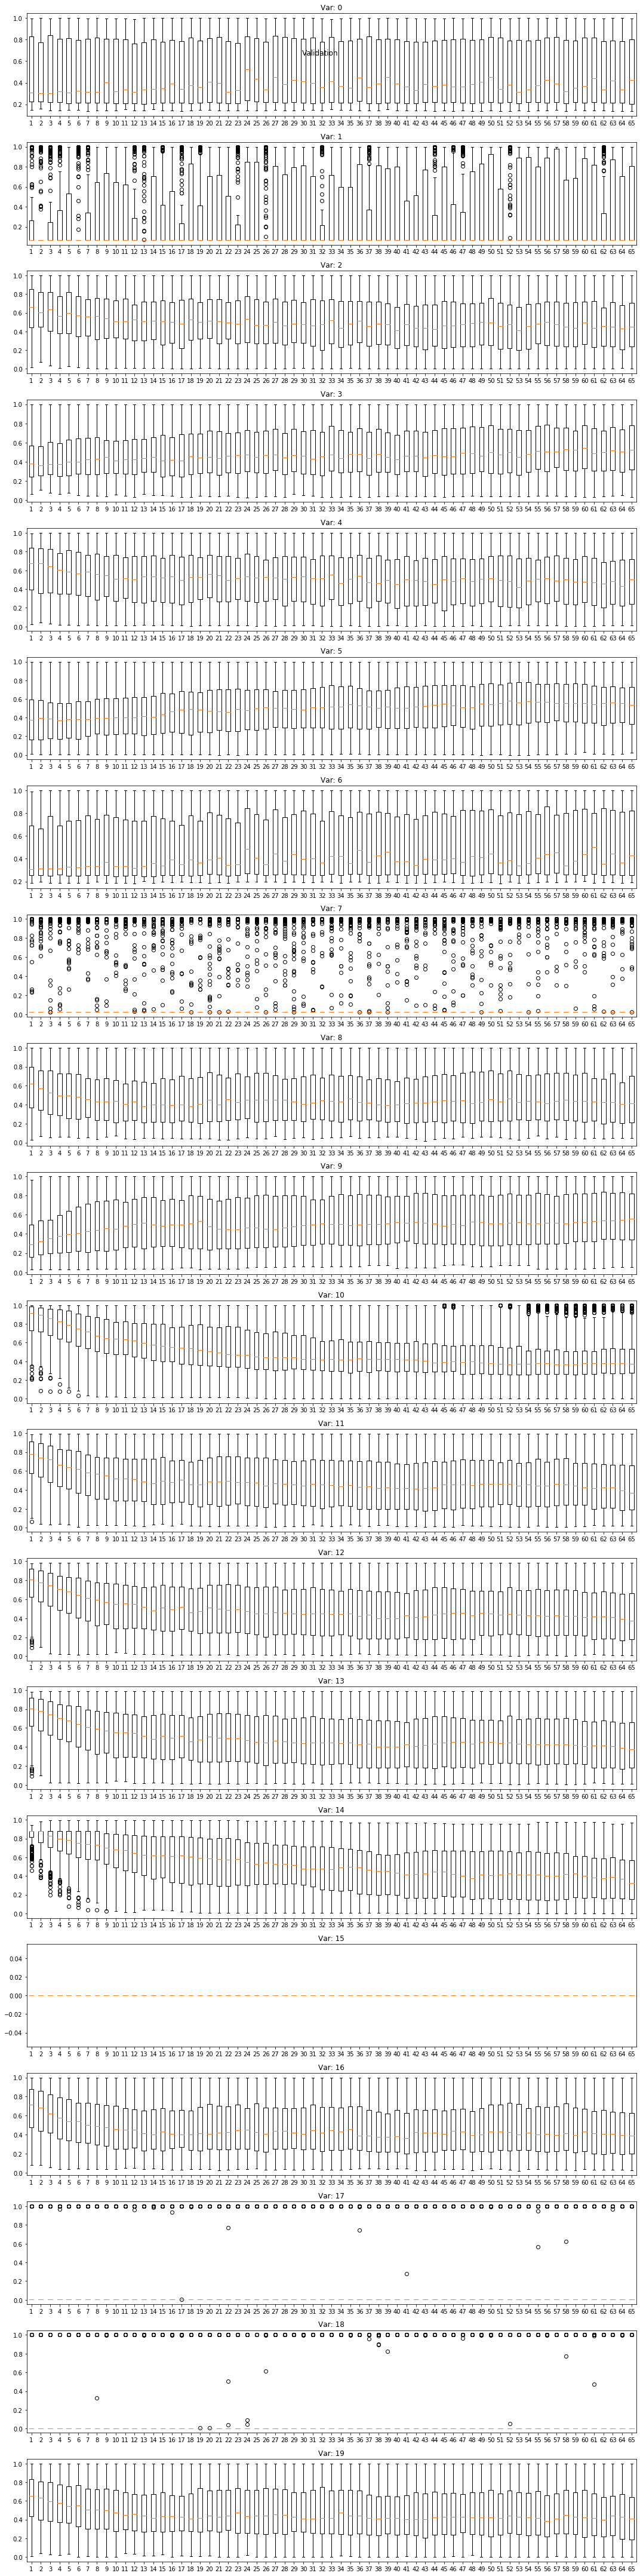

In [21]:
boxplt (val_contin_input, 'Validation')

**DIDN'T USE ANYTHING BELOW**

In [ ]:
raise Exception()

## Normalization 

Two ways:

1- log(x- min(x) + 1 ) 

2- GL algorithm

In [ ]:
def boxplt_hl (data, ttl, hl): 
    fig, axX = plt.subplots(20, 1, figsize=(15, 60))
    for idx in range(20):
        ax = axX.flatten()[idx]
        df = pd.DataFrame(data[:, :, idx])
        ax.boxplot(df.values)
        ax.hlines(hl[idx][0], xmin=0, xmax=65)
        ax.hlines(hl[idx][1], xmin=0, xmax=65)
        ax.hlines(hl[idx][2], xmin=0, xmax=65)
        ax.set_title('Var: {}'.format(idx))
    plt.tight_layout()
    fig.suptitle(ttl) 

In [ ]:
# train_contin_input_norm = torch.zeros_like(train_contin_input)
train_contin_input_norm = np.zeros_like(train_contin_input)
hl = [None] * 20
for idx in range(20):
    d = np.log(train_contin_input[:, :, idx].data.numpy() + 2.5)
    mnV = d.ravel().min()
    mxV = d.ravel().max()
    p = np.percentile(d.ravel(), [99, 97.5, 95])
    hl[idx] = p
    print(idx, mnV, mxV, p)
    train_contin_input_norm[:,:,idx] = (d - mnV) / (mxV - mnV)
#     print(pd.DataFrame(train_contin_input_norm[:, :, idx].data.numpy()).describe())

In [ ]:
boxplt_hl (train_contin_input_norm, 'Train', hl)

In [ ]:
# import matlab.engine
# eng = matlab.engine.start_matlab()